<p align="center"><img width="50%" src="https://aimodelsharecontent.s3.amazonaws.com/aimodshare_banner.jpg" /></p>


---




<p align="center"><h1 align="center">Flower Image Classification Tutorial</h1> <h3 align="center">(Prepare to deploy model and preprocessor to REST API/Web Dashboard in four easy steps...)</h3></p>
<p align="center"><img width="80%" src="https://aimodelsharecontent.s3.amazonaws.com/ModelandPreprocessorObjectPreparation.jpeg" /></p>


---



## **(1) Preprocessor Function & Setup**

In [ ]:
# Importing images from tensorflow compressed .tgz file...
FLOWERS_DIR = 'flower_photos' # Downloading to this directory drom the download URL.
def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz') # Like ```urlopen```.
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)

import os
from six.moves import urllib

# Download the images to flower_photos folder...
download_images()

Flower photos are located in flower_photos


In [ ]:
# Extracting all filepaths iteratively...
base_path = 'flower_photos'
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Load file paths to fnames list object...
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

# print('number of images for each category:', [len(f) for f in fnames])
# print(fnames[0:4]) # Examples of file names...

### **Write a Preprocessor Function**


> ### Preprocessor functions for image prediction models can use ***cv2*** and ***numpy*** to read in and preprocess images.  

In [ ]:
def preprocessor(data, shape=(192, 192)):
        """
        This function preprocesses reads in images, resizes them to a fixed shape and
        min/max transforms them before converting feature values to float32 numeric values
        required by onnx files.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.


        # Resize all the images...
        X = np.array(img)
        X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels].
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

In [ ]:
import numpy as np

# Import image, load to array of shape height, width, channels, then min/max transform...

# Read in all images from filenames...
preprocessed_image_data = [preprocessor(x) for x in fnames[0] + fnames[1] + fnames[2] + fnames[3] + fnames[4]]

# Object needs to be an array rather than a list for Keras. (vstack converts above list to array object.)
X = np.vstack(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model.

In [ ]:
X.shape

(3670, 192, 192, 3)

In [ ]:
print(len(preprocessed_image_data)) # Same number of elements as filenames.
print(preprocessed_image_data[0].shape) # Dimensions now 192, 192, 3 for all images.
print(preprocessed_image_data[0].min()) # Min value of every image is zero.
print(preprocessed_image_data[0].max()) # Max value of every image is one
X.shape

3670
(1, 192, 192, 3)
0.0
1.0


(3670, 192, 192, 3)

In [ ]:
# Create y data made up of correctly ordered labels from file folders...
from itertools import repeat

daisy = list(repeat("daisy", 633)) #i.e.: 633 filenames in daisy folder
dandelion = list(repeat("dandelion", 898))
roses = list(repeat("roses", 641))
sunflowers = list(repeat("sunflowers", 699))
tulips = list(repeat("tulips", 799))

# Combine into single list of y labels...
y_labels = daisy + dandelion + roses + sunflowers + tulips

# Check length, same as X above...
len(y_labels) 

# Need to one-hot encode for Keras. Let's use Pandas...
import pandas as pd
y = pd.get_dummies(y_labels)
display(y)

,daisy,dandelion,roses,sunflowers,tulips
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
3665,0,0,0,0,1
3666,0,0,0,0,1
3667,0,0,0,0,1
3668,0,0,0,0,1


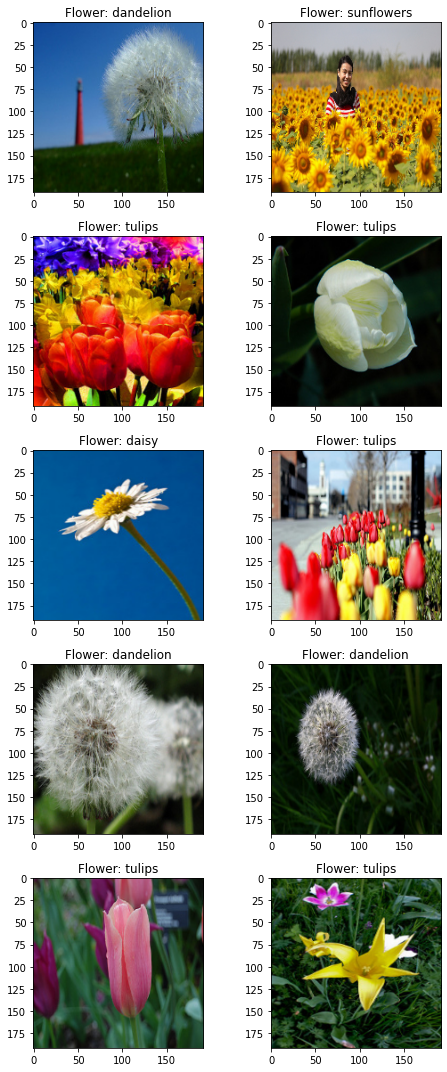

In [ ]:
# Visualize images...
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(5, 2)
fig.set_size_inches(7, 15)
for i in range(5):
    for j in range (2):
        l = np.random.randint(0, len(y_labels))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: ' + y_labels[l])
        
plt.tight_layout()

In [ ]:
# train_test_split resized images...
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)
y_train 

,daisy,dandelion,roses,sunflowers,tulips
1997,0,0,1,0,0
1875,0,0,1,0,0
2840,0,0,0,1,0
2631,0,0,0,1,0
1605,0,0,1,0,0
...,...,...,...,...,...
3484,0,0,0,0,1
1634,0,0,1,0,0
1741,0,0,1,0,0
1689,0,0,1,0,0


## **(2) Train Model Using Keras (or Your Preferred ML Library)**

### Keras **Convolutional Neural Network**

In [ ]:
# Let's build a convnet model...
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
import tensorflow as tf
with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
                                 
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=[192, 192, 3]))
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=[192, 192, 3]))
        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
        model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(100, activation='relu')) # One fully-connected layer of 100 neurons.
        model.add(Dropout(0.2))

        model.add(Dense(5, activation='softmax')) # Last fully-connected layer of 5 outputs (5 categories).

        # Compile model...
        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        # Fitting the NN to the Training set...
        hist = model.fit(X_train, y_train,
                          epochs=5, verbose=1, validation_data=(X_test, y_test))

Epoch 1/5
92/92 [==============================] - 8s 88ms/step - loss: 1.4444 - accuracy: 0.3743 - val_loss: 1.1810 - val_accuracy: 0.5354
Epoch 2/5
92/92 [==============================] - 7s 80ms/step - loss: 1.1475 - accuracy: 0.5351 - val_loss: 1.1889 - val_accuracy: 0.5708
Epoch 3/5
92/92 [==============================] - 7s 81ms/step - loss: 0.9835 - accuracy: 0.6196 - val_loss: 0.9715 - val_accuracy: 0.6253
Epoch 4/5
92/92 [==============================] - 7s 81ms/step - loss: 0.8498 - accuracy: 0.6843 - val_loss: 1.1107 - val_accuracy: 0.5668
Epoch 5/5
92/92 [==============================] - 8s 82ms/step - loss: 0.7079 - accuracy: 0.7391 - val_loss: 0.9627 - val_accuracy: 0.6649


## **(3) Save Preprocessor**

In [ ]:
# ! pip3 install aimodelshare

In [ ]:
def export_preprocessor(preprocessor_function, filepath):
    import dill
    with open(filepath, "wb") as f:
        dill.dump(preprocessor_function, f)

# import aimodelshare as ai # Once we can deploy this, we use it in lieu of the below.
# ai.export_preprocessor(preprocessor, "preprocessor.pkl")

export_preprocessor(preprocessor, "preprocessor.pkl")

## **(4) Save Keras Model to Onnx File Format**


In [ ]:
# Load libraries for onnx model conversion (keras to onnx).
! pip3 install keras2onnx
! pip3 install onnxruntime

In [ ]:
# Save model to onnx file...

import os
os.environ['TF_KERAS'] = '1' # Add this environmental variable whenever you use tensorflow's tf.keras to build your keras model.

import onnx
import keras2onnx

# Convert model to onnx object...
import onnx
from keras2onnx import convert_keras # Specific to your architecture.
onnx_model = convert_keras(model, 'my_model.onnx')

# Save model to local .onnx file...
with open("my_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 49 -> 24
